In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

import numpy as np
import pandas as pd
from scipy.signal import find_peaks,peak_widths
import os, sys, re, copy, math
from tqdm.auto import tqdm

home = '/home/anibal/'
sys.path.append(home + '/roman_rubin/')
from functions_roman_rubin import read_data
# this codes are in the /fit_codes directory 
# https://github.com/anibal-art/roman_rubin/tree/main/fit_codes
# from fit_results import chi_dof, best_model, event_fits, sigmas
# from filter_curves import read_curves
# from analysis_metrics import m1,m2,m3, fit_true, metrics, sigma_ratio, bias_ratio, fit_values
# from plot_models import plot_LCmodel
# from plot_lightcurves import model

sys.path.append(home + '/che/archive/photutils')
from bandpass import Bandpass
from signaltonoise import calc_mag_error_m5
from photometric_parameters import PhotometricParameters

#astropy 
import astropy.units as u
from astropy import constants as const
from astropy.table import QTable
from astropy.time import Time
from astropy.coordinates import SkyCoord

#pyLIMA
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.toolbox import time_series
from pyLIMA.simulations import simulator
from pyLIMA.models import PSBL_model
from pyLIMA.models import USBL_model
from pyLIMA.models import FSPLarge_model
from pyLIMA.models import PSPL_model
from pyLIMA.fits import TRF_fit
from pyLIMA.fits import DE_fit
from pyLIMA.fits import MCMC_fit
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA.outputs import file_outputs

import multiprocessing as mul
import h5py

In [2]:
def model_rubin_roman(Source,true_model,event_params, path_ephemerides,model, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
                    lsst_y):
    '''
    Perform fit for Rubin and Roman data for fspl, usbl and pspl
    '''
    
    tlsst = 60350.38482057137 + 2400000.5
    RA, DEC = 267.92497054815516, -29.152232510353276
    e = event.Event(ra=RA, dec=DEC)

    if len(lsst_u) + len(lsst_g) + len(lsst_r) + len(lsst_i) + len(lsst_z) + len(lsst_y) == 0:
        e.name = 'Event_Roman_' + str(int(Source))
    else:
        e.name = 'Event_RR_' + str(int(Source))
    tel_list = []

    # Add a PyLIMA telescope object to the event with the Gaia lightcurve
    tel1 = telescopes.Telescope(name='Roman', camera_filter='W149',
                                light_curve=wfirst_lc,
                                light_curve_names=['time', 'mag', 'err_mag'],
                                light_curve_units=['JD', 'mag', 'mag'],
                                location='Space')

    ephemerides = np.loadtxt(path_ephemerides)
    ephemerides[:, 0] = ephemerides[:, 0]
    ephemerides[:, 3] *= 60 * 300000 / 150000000
    deltaT = tlsst - ephemerides[:, 0][0]
    ephemerides[:, 0] = ephemerides[:, 0] + deltaT
    tel1.spacecraft_positions = {'astrometry': [], 'photometry': ephemerides}
    e.telescopes.append(tel1)
    tel_list.append('Roman')
    
    lsst_lc_list = [lsst_u,lsst_g,lsst_r,lsst_i,lsst_z,lsst_y]
    lsst_bands = "ugrizy"
    for j in range(len(lsst_lc_list)):
        if not len(lsst_lc_list[j])==0:
            tel = telescopes.Telescope(name=lsst_bands[j], camera_filter=lsst_bands[j],
                                light_curve=lsst_lc_list[j],
                                light_curve_names=['time', 'mag', 'err_mag'],
                                light_curve_units=['JD', 'mag', 'mag'],
                                location='Earth')
            e.telescopes.append(tel)
            tel_list.append(lsst_bands[j])
    e.check_event()
    # Give the model initial guess values somewhere near their actual values so that the fit doesn't take all day
    t0 = float(event_params['t0'])
        # t0 = float(event_params['t_center'])
    # u0 = float(event_params['u_center'])
    
    # rango = 0.5
    if model == 'FSPL':
        pyLIMAmodel = FSPLarge_model.FSPLargemodel(e, parallax=['Full', t0])
    elif model=='USBL':
        if true_model:
            pyLIMAmodel = USBL_model.USBLmodel(e, origin=['third_caustic', [0, 0]],
                                               blend_flux_parameter='ftotal',
                                               parallax=['Full', t0])
        else:
            pyLIMAmodel = USBL_model.USBLmodel(e, blend_flux_parameter='ftotal', parallax=['Full', t0])
    elif model=='PSPL':
        pyLIMAmodel = PSPL_model.PSPLmodel(e, parallax=['Full', t0])
    return pyLIMAmodel


In [3]:
ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
          'i':27.85, 'z':27.46, 'y':26.68}
colorbands={'W149':'b', 'u':'purple', 'g':'g', 'r':'red',
          'i':'yellow', 'z':'k', 'y':'cyan'}


i=18#18#34 cat B #18 good
nset=1
path_event = f'/home/anibal/results_roman_rubin/PB_new_format2/PB/set_sim{nset}/Event_{i}.h5'
path_fit_rr = f'/home/anibal/results_roman_rubin/PB_new_format2/PB/set_fit{nset}/Event_RR_{i}_TRF.npy'
path_fit_roman = f'/home/anibal/results_roman_rubin/PB_new_format2/PB/set_fit{nset}/Event_Roman_{i}_TRF.npy'
path_TRILEGAL = f"/home/anibal/results_roman_rubin/PB_planet_split_{nset}.csv"
model_ulens = 'USBL'

path_ephemerides = '/home/anibal/files_db/james_webb.txt'
path_dataslice = '/home/anibal/roman_rubin/simulation/dataSlice_baseline.npy'

info_dataset, pyLIMA_parameters, bands = read_data(path_event)


In [4]:
ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
          'i':27.85, 'z':27.46, 'y':26.68}
colorbands={'W149':'b', 'u':'purple', 'g':'g', 'r':'red',
          'i':'yellow', 'z':'k', 'y':'cyan'}

i=24789#34 cat B #18 good
nset=int(i/5000)
print(nset)
print(i-5000*nset)
# path_event = f'/home/anibal/results_roman_rubin/PB_new_format2/PB/set_sim{nset}/Event_{i}.h5'
# path_fit_rr = f'/home/anibal/results_roman_rubin/PB_new_format2/PB/set_fit{nset}/Event_RR_{i}_TRF.npy'
# path_fit_roman = f'/home/anibal/results_roman_rubin/PB_new_format2/PB/set_fit{nset}/Event_Roman_{i}_TRF.npy'
# path_TRILEGAL = f"/home/anibal/results_roman_rubin/PB_planet_split_{nset}.csv"
# model_ulens = 'USBL'

# path_event = f'/home/anibal/results_roman_rubin/FFP_final/FFP/set_sim{nset}/Event_{i}.h5'
# path_fit_rr = f'/home/anibal/results_roman_rubin/FFP_final/FFP/set_fit{nset}/Event_RR_{i}_TRF.npy'
# path_fit_roman = f'/home/anibal/results_roman_rubin/FFP_final/FFP/set_fit{nset}/Event_Roman_{i}_TRF.npy'
# path_TRILEGAL = f"/home/anibal/results_roman_rubin/FFP_uni_split_{nset}.csv"
# model_ulens = 'FSPL'

path_event = f'/home/anibal/results_roman_rubin/BH_final/BH/set_sim{nset}/Event_{i-5000*nset}.h5'
# print(os.listdir(path_event))
path_fit_rr = f'/home/anibal/results_roman_rubin/BH_final/BH/set_fit{nset}/Event_RR_{i-5000*nset}_TRF.npy'
path_fit_roman = f'/home/anibal/results_roman_rubin/BH_final/BH/set_fit{nset}/Event_Roman_{i-5000*nset}_TRF.npy'
path_TRILEGAL = f"/home/anibal/roman_rubin/TRILEGAL//BH_split_{nset}.csv"
model_ulens = 'PSPL'

path_ephemerides = '/home/anibal/files_db/james_webb.txt'
path_dataslice = '/home/anibal/roman_rubin/simulation/dataSlice_baseline.npy'

info_dataset, pyLIMA_parameters, bands = read_data(path_event)
# print('pyLIMA_parameters saved -------------',pyLIMA_parameters)
data_fit_rr = np.load(path_fit_rr,allow_pickle=True).item()
data_fit_roman = np.load(path_fit_roman,allow_pickle=True).item()
pd_planets = pd.read_csv(path_TRILEGAL)
# print()
# data = pd_planets.iloc[i-5000*nset]
# print(data)
# my_own_model, pyLIMA_parameters, all_residuals, decision = sim_event(i, data, path_ephemerides, path_dataslice,model_ulens)
# print(('mass_ratio' and 'rho') in pyLIMA_parameters.keys())
# print('pyLIMA_parameters sim --------------',pyLIMA_parameters)


4
4789


In [5]:
print(data_fit_rr['best_model'])
print(data_fit_roman['best_model'])
info_dataset, pyLIMA_parameters, bands = read_data(path_event)
print(pyLIMA_parameters)
ulens_params = []
# PAR = ['t_center','u_center','tE','rho','separation','mass_ratio','alpha','piEN','piEE']
PAR = ['t0','u0','tE','piEN','piEE']
for b in (PAR):
    ulens_params.append(pyLIMA_parameters[b])
flux_params = []
for b in bands:
    if not len(bands[b])==0:
        zp_Rubin_to_pyLIMA = (10**((-27.4+ZP[b])/2.5))
        
        flux_params.append(pyLIMA_parameters['fsource_'+b]/zp_Rubin_to_pyLIMA)
        flux_params.append(pyLIMA_parameters['ftotal_'+b]/zp_Rubin_to_pyLIMA)
        
true_params = ulens_params+flux_params

[2462210.2024307023, -0.2557116925843916, 354.2784590933747, 0.001045551705384151, -0.005582030132171227, 95.29132402007217, 134.56059443910092, 7.657973786623787, 19.792877249628617, 28.726736607811436, 50.83428159996666, 91.58995007033067, 95.43320661189699]
[2462210.383248619, -0.14922339624236897, 374.95855070284773, 0.0031366551155352545, -0.005338487971396369, 81.86712169112421, 134.43535453823327]
{'fblend_W149': 49.94846932134996, 'fblend_g': 4.321642961047378, 'fblend_i': 33.37670053432787, 'fblend_r': 9.063989531384266, 'fblend_u': 0.0677772411782082, 'fblend_y': 31.148908192847834, 'fblend_z': 1.7697399059402414, 'fsource_W149': 114.06518309009383, 'fsource_g': 5.733772057513058, 'fsource_i': 43.394794842575024, 'fsource_r': 19.670269335364466, 'fsource_u': 0.09910110995833103, 'fsource_y': 32.70684031503601, 'fsource_z': 98.0462228432323, 'ftotal_W149': 164.0136524114438, 'ftotal_g': 10.055415018560437, 'ftotal_i': 76.77149537690289, 'ftotal_r': 28.734258866748732, 'ftotal_

In [6]:
data_fit_rr['best_model']

[2462210.2024307023,
 -0.2557116925843916,
 354.2784590933747,
 0.001045551705384151,
 -0.005582030132171227,
 95.29132402007217,
 134.56059443910092,
 7.657973786623787,
 19.792877249628617,
 28.726736607811436,
 50.83428159996666,
 91.58995007033067,
 95.43320661189699]

In [7]:
# ulens_params

In [8]:
true_params

[2462210.839002816,
 0.2452248400858135,
 356.88396067604,
 0.0020911034107683,
 -0.0052061321626452,
 93.57354910222196,
 134.54885304690197,
 9.768104712801986,
 14.269212315793636,
 28.67065663012306,
 50.72242398926505,
 92.7749795858179,
 94.44957325077057]

In [9]:

Source = 18
event_params = pyLIMA_parameters
event_params['te']=event_params['tE']
# event_params['s']=event_params['separation']
# event_params['q']=event_params['mass_ratio']

f= 'W149'
wfirst_lc = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f = 'u'
lsst_u = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='g'
lsst_g = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='r'
lsst_r = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='i'
lsst_i = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_z = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_y = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T

model_true = model_rubin_roman(Source,True,event_params, path_ephemerides,model_ulens, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
                    lsst_y)

# {'t_center':data_fit_rr['best_model'][0]}
model_rr = model_rubin_roman(Source,False,event_params, path_ephemerides,model_ulens, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
                    lsst_y)
# {'t_center':data_fit_roman['best_model'][0]}
model_roman = model_rubin_roman(Source,False,event_params, path_ephemerides,model_ulens, wfirst_lc, [], [], [], [], [],[])

# model1 = model_rubin_roman(Source,event_params, path_ephemerides,model_ulens, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
#                     lsst_y)

check_event  : Everything looks fine...


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: Er

Parallax(Full) estimated for the telescope Roman: SUCCESS


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 11 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 44 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 44 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 44 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWa

Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman: SUCCESS


In [10]:
from pyLIMA.outputs import pyLIMA_plots
from cycler import cycler
plt.close('all')
# custom_cycler = (cycler(color=custom_color))

# pyLIMA_plots.MARKERS_COLORS = custom_cycler
# pyLIMA_plots.MARKER_SYMBOLS = np.array([custom_marker])
### Find the telescope fluxes if needed

if len(data_fit_rr['best_model']) != len(model_rr.model_dictionnary):
    telescopes_fluxes = model_rr.find_telescopes_fluxes(data_fit_rr['best_model'])
    print(telescopes_fluxes)
    print(telescopes_fluxes['fsource_Roman'])
    telescopes_fluxes = [telescopes_fluxes[key] for key in
                         telescopes_fluxes]#._fields]
    model_parameters1 = np.r_[data_fit_rr['best_model'], telescopes_fluxes]
    print(model_parameters1)
else:
    print('its here')
    model_parameters1 = data_fit_rr['best_model']

    
if len(data_fit_roman['best_model']) != len(model_roman.model_dictionnary):
    # print(model_roman)
    telescopes_fluxes = model_roman.find_telescopes_fluxes(data_fit_roman['best_model'])
    telescopes_fluxes = [telescopes_fluxes[key] for key in
                         telescopes_fluxes]#._fields]
    model_parameters2 = np.r_[data_fit_rr['best_model'], telescopes_fluxes]
else:
    model_parameters2 = data_fit_rr['best_model']
    
# if len(true_params) != len(model_true.model_dictionnary):
#     telescopes_fluxes = model_true.find_telescopes_fluxes(true_params)
#     telescopes_fluxes = [getattr(telescopes_fluxes, key) for key in
#                          telescopes_fluxes]#._fields]
#     model_parameters3 = np.r_[true_params, telescopes_fluxes]
# else:
#     model_parameters3 = true_params

OrderedDict([('fsource_Roman', 95.29132402007217), ('ftotal_Roman', 229.85191845917308), ('fsource_r', 7.657973786623787), ('ftotal_r', 27.450851036252402), ('fsource_i', 28.726736607811436), ('ftotal_i', 79.56101820777809), ('fsource_z', 91.58995007033067), ('ftotal_z', 187.02315668222766), ('fsource_y', 91.58995008650221), ('ftotal_y', 187.02315669838242)])
95.29132402007217
[ 2.46221020e+06 -2.55711693e-01  3.54278459e+02  1.04555171e-03
 -5.58203013e-03  9.52913240e+01  1.34560594e+02  7.65797379e+00
  1.97928772e+01  2.87267366e+01  5.08342816e+01  9.15899501e+01
  9.54332066e+01  9.52913240e+01  2.29851918e+02  7.65797379e+00
  2.74508510e+01  2.87267366e+01  7.95610182e+01  9.15899501e+01
  1.87023157e+02  9.15899501e+01  1.87023157e+02]


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 67691 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 67691 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman: SUCCESS


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 44455 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 44455 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 44455 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope r: SUCCESS


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 69568 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 69568 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman: SUCCESS


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 67983 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 67983 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman: SUCCESS


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 44790 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 44790 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 44790 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope Roman: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS


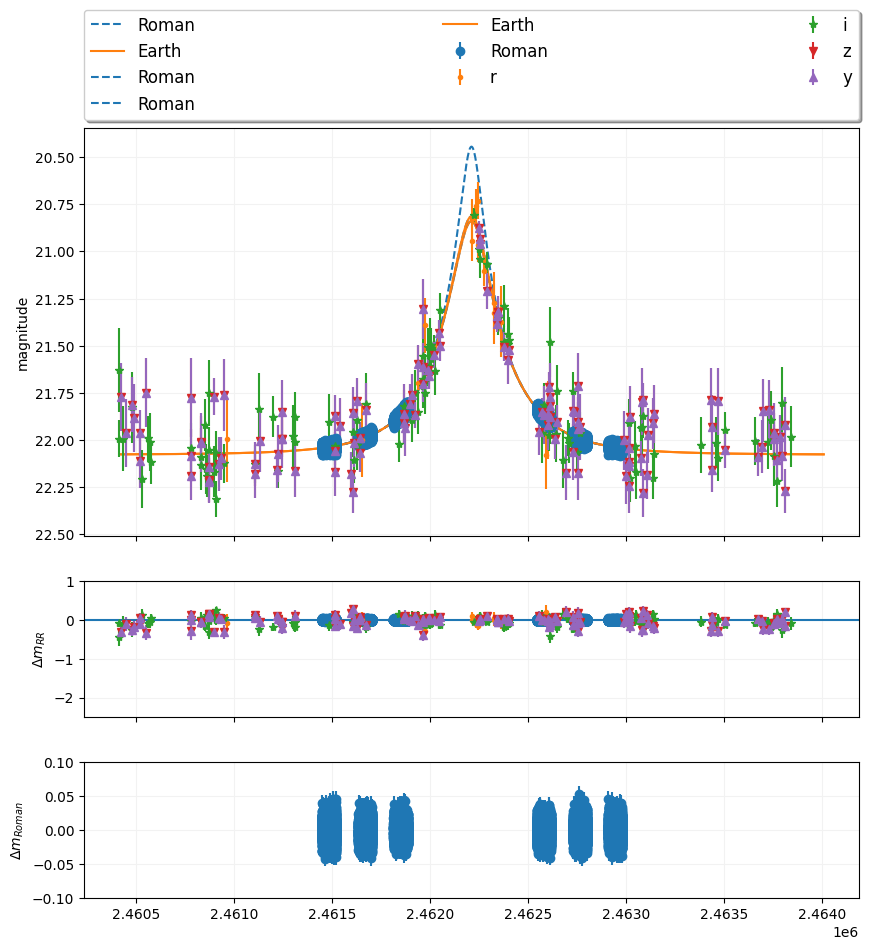

In [11]:


# tmin, tmax = 2460200., data_ogle[-1,0]+5.
# tmin, tmax = 2460160., data_ogle[-1,0]+20.
fig, axes = plt.subplots(3, 1,figsize=(10,10), height_ratios=[3, 1,1], sharex=True)

# Lc plot
axes[0].title.set_text('name')
axes[0].set_ylabel("magnitude") 
axes[0].grid(True, color='0.95')
axes[0].invert_yaxis()
# axes[0].set_xlim(tmin, tmax)
# axes[0].set_ylim(18.5, 12.5) 
# axes[0].set_ylim(17.5, 12.5) 

#Plot model1 and align data to it
pyLIMA_plots.plot_photometric_models(axes[0], model_rr, data_fit_rr['best_model'], plot_unit='Mag')
pyLIMA_plots.plot_photometric_models(axes[0], model_roman, data_fit_roman['best_model'], plot_unit='Mag')
pyLIMA_plots.plot_photometric_models(axes[0], model_true, true_params, plot_unit='Mag')
pyLIMA_plots.plot_aligned_data(axes[0], model_rr, data_fit_rr['best_model'], plot_unit='Mag')
# model_parameters2
# model_parameters3
colors = ['darkslategray', 'gray', 'lightgray']

# for i in range(len(spec_jds)):
#     axes[0].axvline(x=spec_jds[i], label='Spec_'+str(i), ls='--', color=colors[i])

# plot residuals
axes[1].set_ylabel("$\Delta m_{RR} $") 
axes[1].grid(True, color='0.95')
axes[2].set_ylabel("$\Delta m_{Roman} $") 
axes[2].grid(True, color='0.95')

pyLIMA_plots.plot_residuals(axes[1], model_rr, data_fit_rr['best_model'], plot_unit='Mag')
pyLIMA_plots.plot_residuals(axes[2], model_roman, data_fit_roman['best_model'], plot_unit='Mag')
# axes[1].set_xlim(tmin, tmax)
axes[1].set_ylim(-2.5, 1)
axes[1].axhline(y=0)

# for i in range(len(spec_jds)):
#     axes[1].axvline(x=spec_jds[i], ls='--', color=colors[i])

axes[0].legend(shadow=True, fontsize='large',
                          bbox_to_anchor=(0, 1.02, 1, 0.2),
                          loc="lower left",
                          mode="expand", borderaxespad=0, ncol=3)
plt.show()
